Using device: cpu


Training (grid, 10 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (random, 10 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (lhs, 10 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (halton, 10 points):   0%|          | 0/15000 [00:00<?, ?it/s]

/Users/krishna/Library/Caches/pypoetry/virtualenvs/sciml-notebook-vQQXKSXF-py3.11/lib/python3.11/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Training (sobol, 10 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (grid, 20 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (random, 20 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (lhs, 20 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (halton, 20 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (sobol, 20 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (grid, 40 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (random, 40 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (lhs, 40 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (halton, 40 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (sobol, 40 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (grid, 60 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (random, 60 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (lhs, 60 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (halton, 60 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (sobol, 60 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (grid, 80 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (random, 80 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (lhs, 80 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (halton, 80 points):   0%|          | 0/15000 [00:00<?, ?it/s]

Training (sobol, 80 points):   0%|          | 0/15000 [00:00<?, ?it/s]

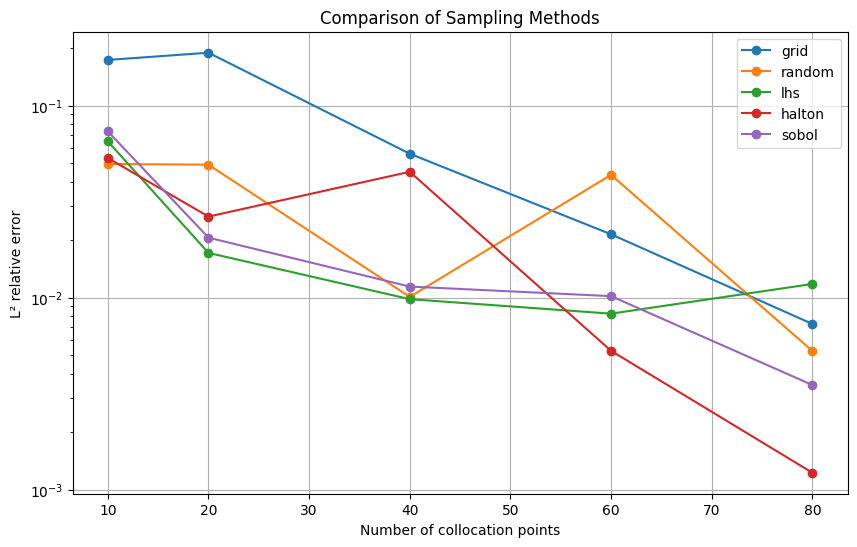

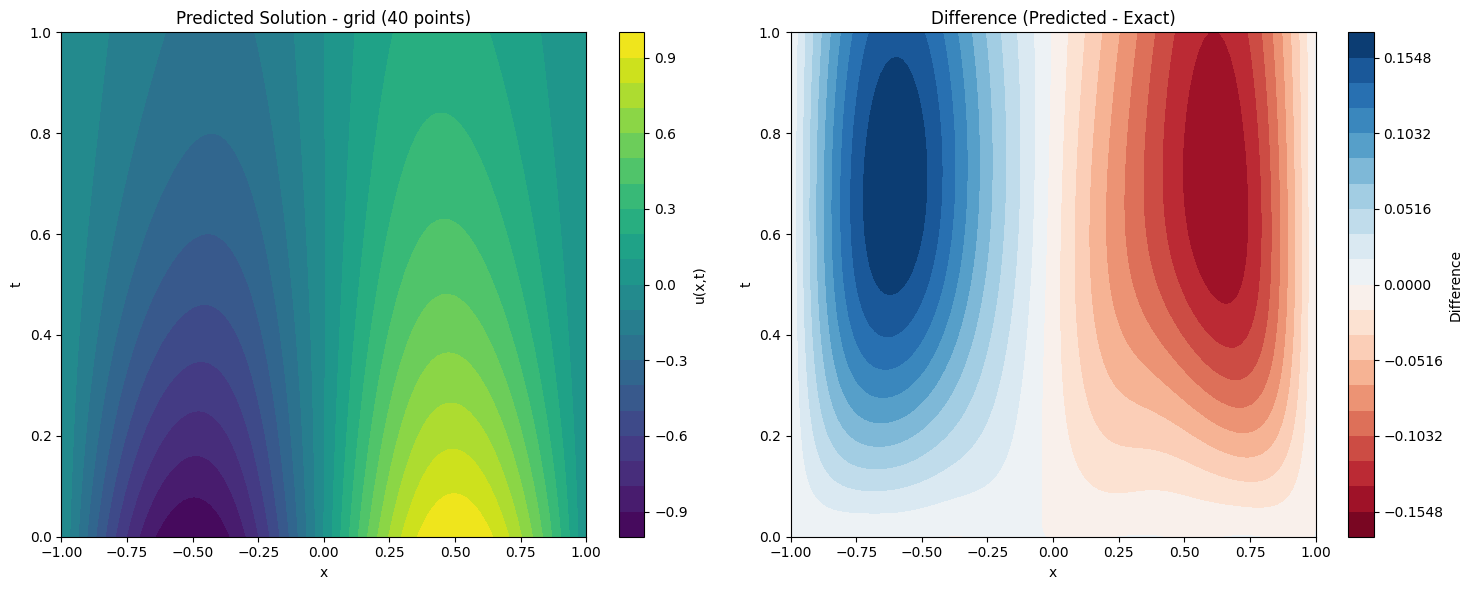

Maximum absolute difference: 1.72e-01


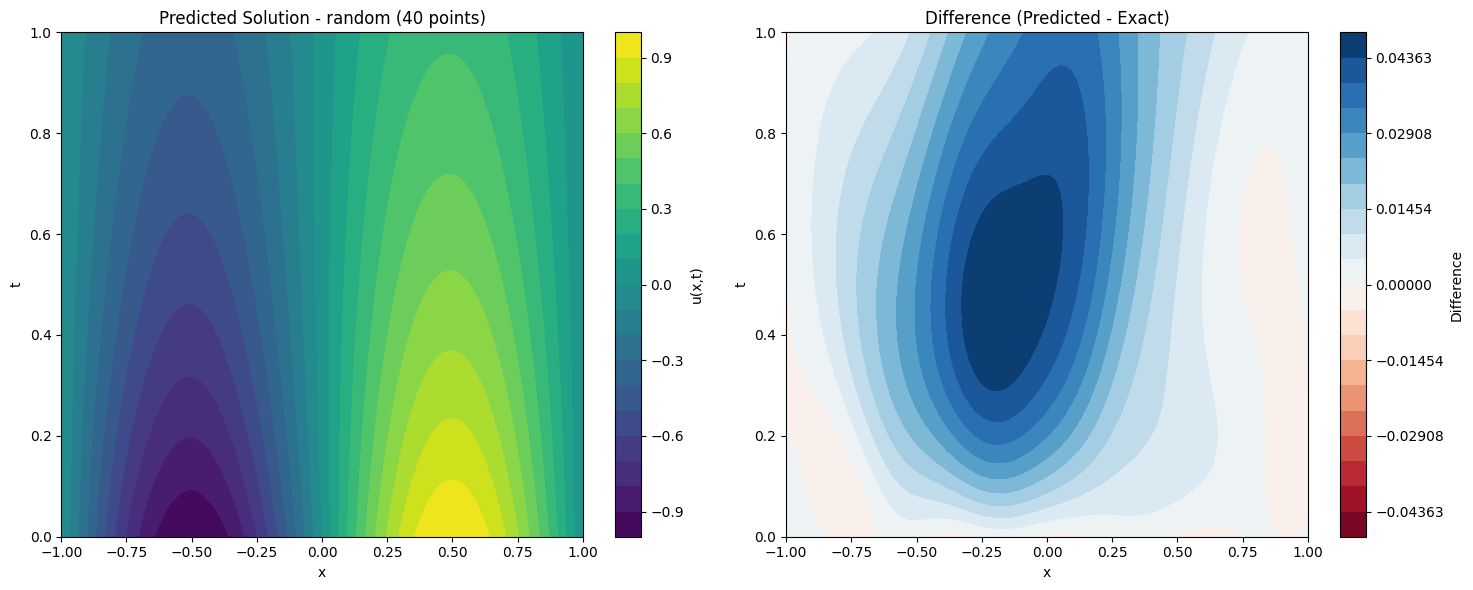

Maximum absolute difference: 4.85e-02


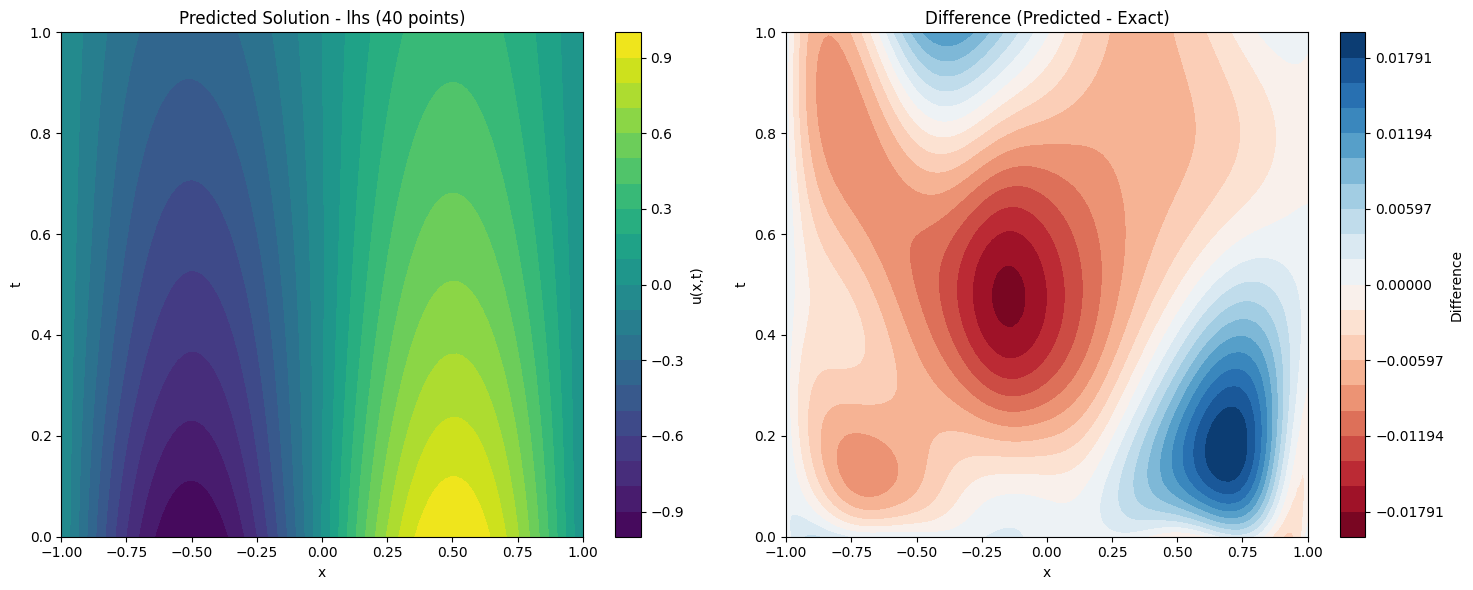

Maximum absolute difference: 1.99e-02


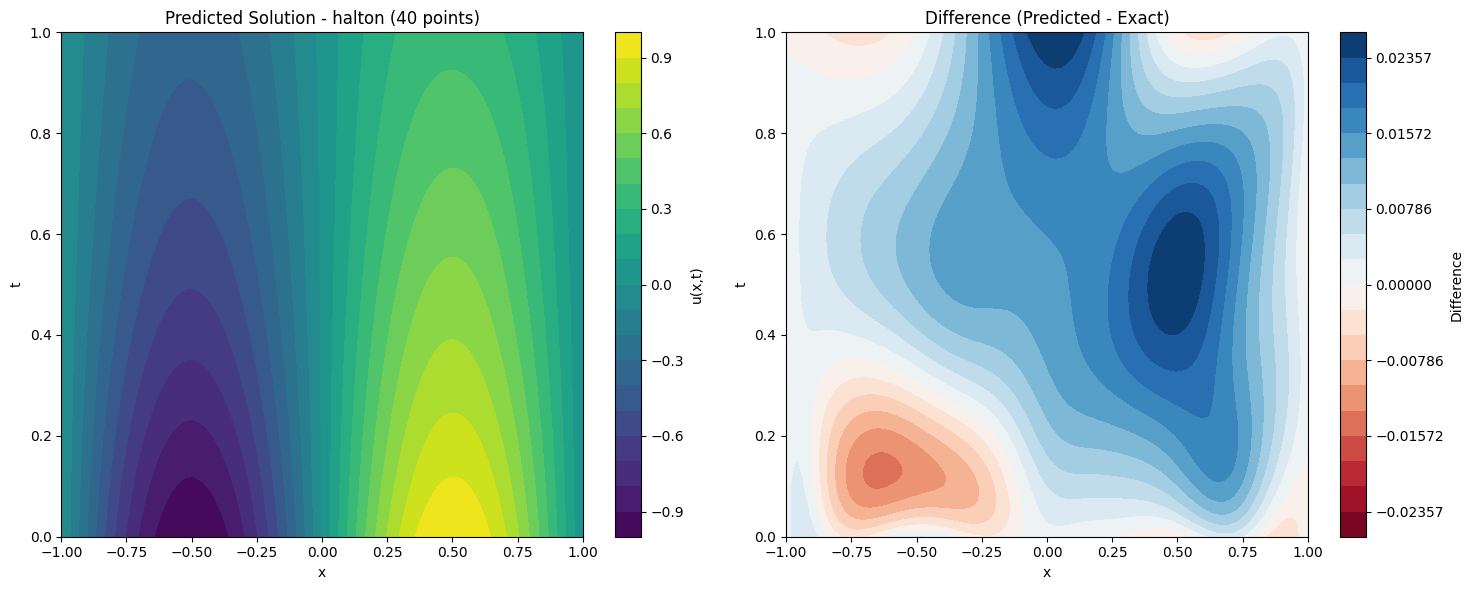

Maximum absolute difference: 2.62e-02


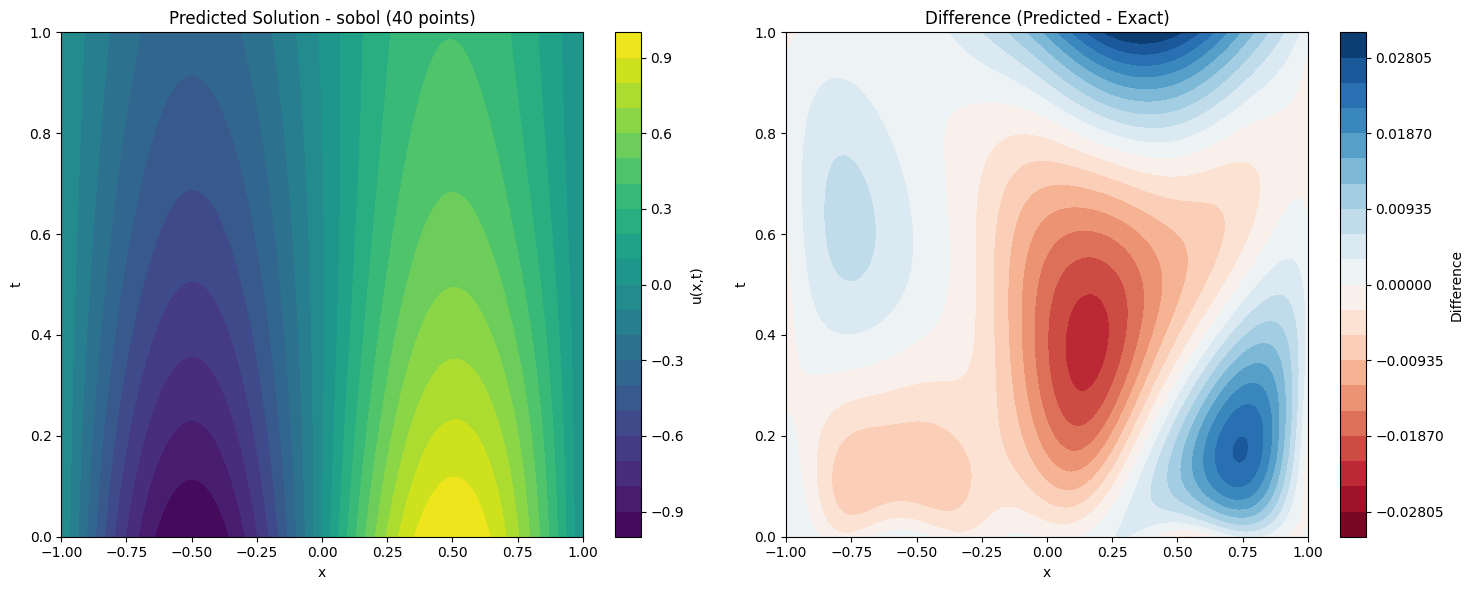

Maximum absolute difference: 3.12e-02

Final L² errors:
grid      : 7.30e-03
random    : 5.28e-03
lhs       : 1.18e-02
halton    : 1.23e-03
sobol     : 3.51e-03


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from tqdm.auto import tqdm
import seaborn as sns

class DiffusionProblem:
    """Defines the diffusion problem parameters and exact solution"""
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print(f"Using device: {device}")
    
    def exact_solution(self, x, t):
        """Compute exact solution u(x,t) = sin(πx)exp(-t)"""
        return torch.sin(np.pi * x) * torch.exp(-t)
    
    def source_term(self, x, t):
        """Compute source term of the PDE"""
        return torch.exp(-t) * (-torch.sin(np.pi * x) + np.pi**2 * torch.sin(np.pi * x))

class PINN(torch.nn.Module):
    """Physics-Informed Neural Network for solving diffusion equation"""
    def __init__(self, problem, hidden_layers=4, neurons=50):
        super().__init__()
        self.problem = problem
        
        layers = []
        layers.append(torch.nn.Linear(2, neurons))
        layers.append(torch.nn.Tanh())
        
        for _ in range(hidden_layers):
            layers.append(torch.nn.Linear(neurons, neurons))
            layers.append(torch.nn.Tanh())
            
        layers.append(torch.nn.Linear(neurons, 1))
        
        self.network = torch.nn.Sequential(*layers)
        self.to(problem.device)
    
    def forward(self, x, t):
        return self.network(torch.cat([x, t], dim=1))
    
    def compute_pde_residual(self, x, t):
        """Compute PDE residual using automatic differentiation"""
        x.requires_grad_(True)
        t.requires_grad_(True)
        
        u = self.forward(x, t)
        
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
        
        return u_t - u_xx - self.problem.source_term(x, t)

class PointGenerator:
    """Generates training points using various sampling methods"""
    def __init__(self, problem):
        self.problem = problem
        
    def generate_points(self, n_points, method='grid'):
        if method == 'grid':
            return self._grid_points(n_points)
        elif method == 'random':
            return self._random_points(n_points)
        elif method in ['lhs', 'halton', 'sobol']:
            return self._qmc_points(n_points, method)
        else:
            raise ValueError(f"Unknown sampling method: {method}")
    
    def _grid_points(self, n_points):
        n_per_dim = int(np.sqrt(n_points))
        x = np.linspace(-1, 1, n_per_dim)
        t = np.linspace(0, 1, n_per_dim)
        X, T = np.meshgrid(x, t)
        return (torch.tensor(X.flatten()[:, None], dtype=torch.float32, device=self.problem.device),
                torch.tensor(T.flatten()[:, None], dtype=torch.float32, device=self.problem.device))
    
    def _random_points(self, n_points):
        x = np.random.uniform(-1, 1, (n_points, 1))
        t = np.random.uniform(0, 1, (n_points, 1))
        return (torch.tensor(x, dtype=torch.float32, device=self.problem.device),
                torch.tensor(t, dtype=torch.float32, device=self.problem.device))
    
    def _qmc_points(self, n_points, method):
        sampler = {
            'lhs': qmc.LatinHypercube(d=2),
            'halton': qmc.Halton(d=2),
            'sobol': qmc.Sobol(d=2)
        }[method]
        
        samples = sampler.random(n=n_points)
        x = 2 * samples[:, 0:1] - 1
        t = samples[:, 1:2]
        return (torch.tensor(x, dtype=torch.float32, device=self.problem.device),
                torch.tensor(t, dtype=torch.float32, device=self.problem.device))

class DiffusionSolver:
    """Main solver class that handles training and visualization"""
    def __init__(self, problem):
        self.problem = problem
        self.point_generator = PointGenerator(problem)
    
    def train(self, n_points, sampling_method, n_epochs=15000):
        """Train PINN with given number of points and sampling method"""
        model = PINN(self.problem)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Generate training points
        x_interior, t_interior = self.point_generator.generate_points(n_points, sampling_method)
        
        # Generate boundary points
        n_boundary = 200
        x_boundary = torch.linspace(-1, 1, n_boundary, device=self.problem.device).reshape(-1, 1)
        t_boundary = torch.zeros(n_boundary, 1, device=self.problem.device)
        
        # Add corner points
        corners_x = torch.tensor([-1., -1., 1., 1.], device=self.problem.device).reshape(-1, 1)
        corners_t = torch.tensor([0., 1., 0., 1.], device=self.problem.device).reshape(-1, 1)
        
        pbar = tqdm(range(n_epochs), desc=f'Training ({sampling_method}, {n_points} points)')
        for epoch in pbar:
            optimizer.zero_grad()
            
            residual = model.compute_pde_residual(x_interior, t_interior)
            pde_loss = torch.mean(residual**2)
            
            u_initial = model(x_boundary, t_boundary)
            ic_loss = torch.mean((u_initial - self.problem.exact_solution(x_boundary, t_boundary))**2)
            
            t_bc = torch.linspace(0, 1, n_boundary, device=self.problem.device).reshape(-1, 1)
            u_left = model(torch.ones_like(t_bc, device=self.problem.device) * -1, t_bc)
            u_right = model(torch.ones_like(t_bc, device=self.problem.device), t_bc)
            bc_loss = torch.mean(u_left**2 + u_right**2)
            
            u_corners = model(corners_x, corners_t)
            corner_loss = torch.mean(u_corners**2)
            
            loss = pde_loss + 10.0 * ic_loss + 10.0 * bc_loss + 10.0 * corner_loss
            
            loss.backward()
            optimizer.step()
            
            if epoch % 100 == 0:
                pbar.set_postfix({'loss': f'{loss.item():.2e}'})
        
        return model, self.compute_error(model)
    
    def plot_solution_comparison(self, model, method, n_points, n_test=100):
        """Plot predicted solution and its difference from exact solution"""
        x = torch.linspace(-1, 1, n_test, device=self.problem.device)
        t = torch.linspace(0, 1, n_test, device=self.problem.device)
        X, T = torch.meshgrid(x, t, indexing='ij')
        
        X_flat = X.reshape(-1, 1)
        T_flat = T.reshape(-1, 1)
        
        with torch.no_grad():
            pred = model(X_flat, T_flat).reshape(n_test, n_test).cpu().numpy()
            exact = self.problem.exact_solution(X_flat, T_flat).reshape(n_test, n_test).cpu().numpy()
        
        diff = pred - exact
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Predicted solution
        im1 = ax1.contourf(X.cpu().numpy(), T.cpu().numpy(), pred, levels=20, cmap='viridis')
        ax1.set_xlabel('x')
        ax1.set_ylabel('t')
        ax1.set_title(f'Predicted Solution - {method} ({n_points} points)')
        plt.colorbar(im1, ax=ax1, label='u(x,t)')
        
        # Difference plot
        max_diff = np.max(np.abs(diff))
        levels = np.linspace(-max_diff, max_diff, 21)
        im2 = ax2.contourf(X.cpu().numpy(), T.cpu().numpy(), diff, levels=levels, cmap='RdBu')
        ax2.set_xlabel('x')
        ax2.set_ylabel('t')
        ax2.set_title('Difference (Predicted - Exact)')
        plt.colorbar(im2, ax=ax2, label='Difference')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Maximum absolute difference: {np.max(np.abs(diff)):.2e}")
    
    def compute_error(self, model, n_test=1000):
        """Compute L2 relative error"""
        x_test = torch.linspace(-1, 1, n_test, device=self.problem.device).reshape(-1, 1)
        t_test = torch.linspace(0, 1, n_test, device=self.problem.device).reshape(-1, 1)
        X_test, T_test = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
        
        x_test = X_test.reshape(-1, 1)
        t_test = T_test.reshape(-1, 1)
        
        with torch.no_grad():
            u_pred = model(x_test, t_test)
            u_exact = self.problem.exact_solution(x_test, t_test)
            
        return (torch.norm(u_pred - u_exact) / torch.norm(u_exact)).item()

def main():
    # Initialize problem and solver
    problem = DiffusionProblem()
    solver = DiffusionSolver(problem)
    
    # Define sampling methods and points to test
    sampling_methods = ['grid', 'random', 'lhs', 'halton', 'sobol']
    n_points_range = [10, 20, 40, 60, 80]
    
    # Store results
    results = {method: [] for method in sampling_methods}
    models = {}
    
    # Training loop
    for n_points in n_points_range:
        for method in sampling_methods:
            model, error = solver.train(n_points, method)
            results[method].append(error)
            
            # Store model for visualization (middle point count)
            if n_points == 20:
                models[method] = model
    
    # Plot error comparison
    plt.figure(figsize=(10, 6))
    for method in sampling_methods:
        plt.plot(n_points_range, results[method], label=method, marker='o')
    plt.yscale('log')
    plt.xlabel('Number of collocation points')
    plt.ylabel('L² relative error')
    plt.legend()
    plt.grid(True)
    plt.title('Comparison of Sampling Methods')
    plt.show()
    
    # Plot solution comparisons for each method
    for method, model in models.items():
        solver.plot_solution_comparison(model, method, 40)
    
    # Print final errors
    print("\nFinal L² errors:")
    for method in sampling_methods:
        print(f"{method:10s}: {results[method][-1]:.2e}")

if __name__ == '__main__':
    main()


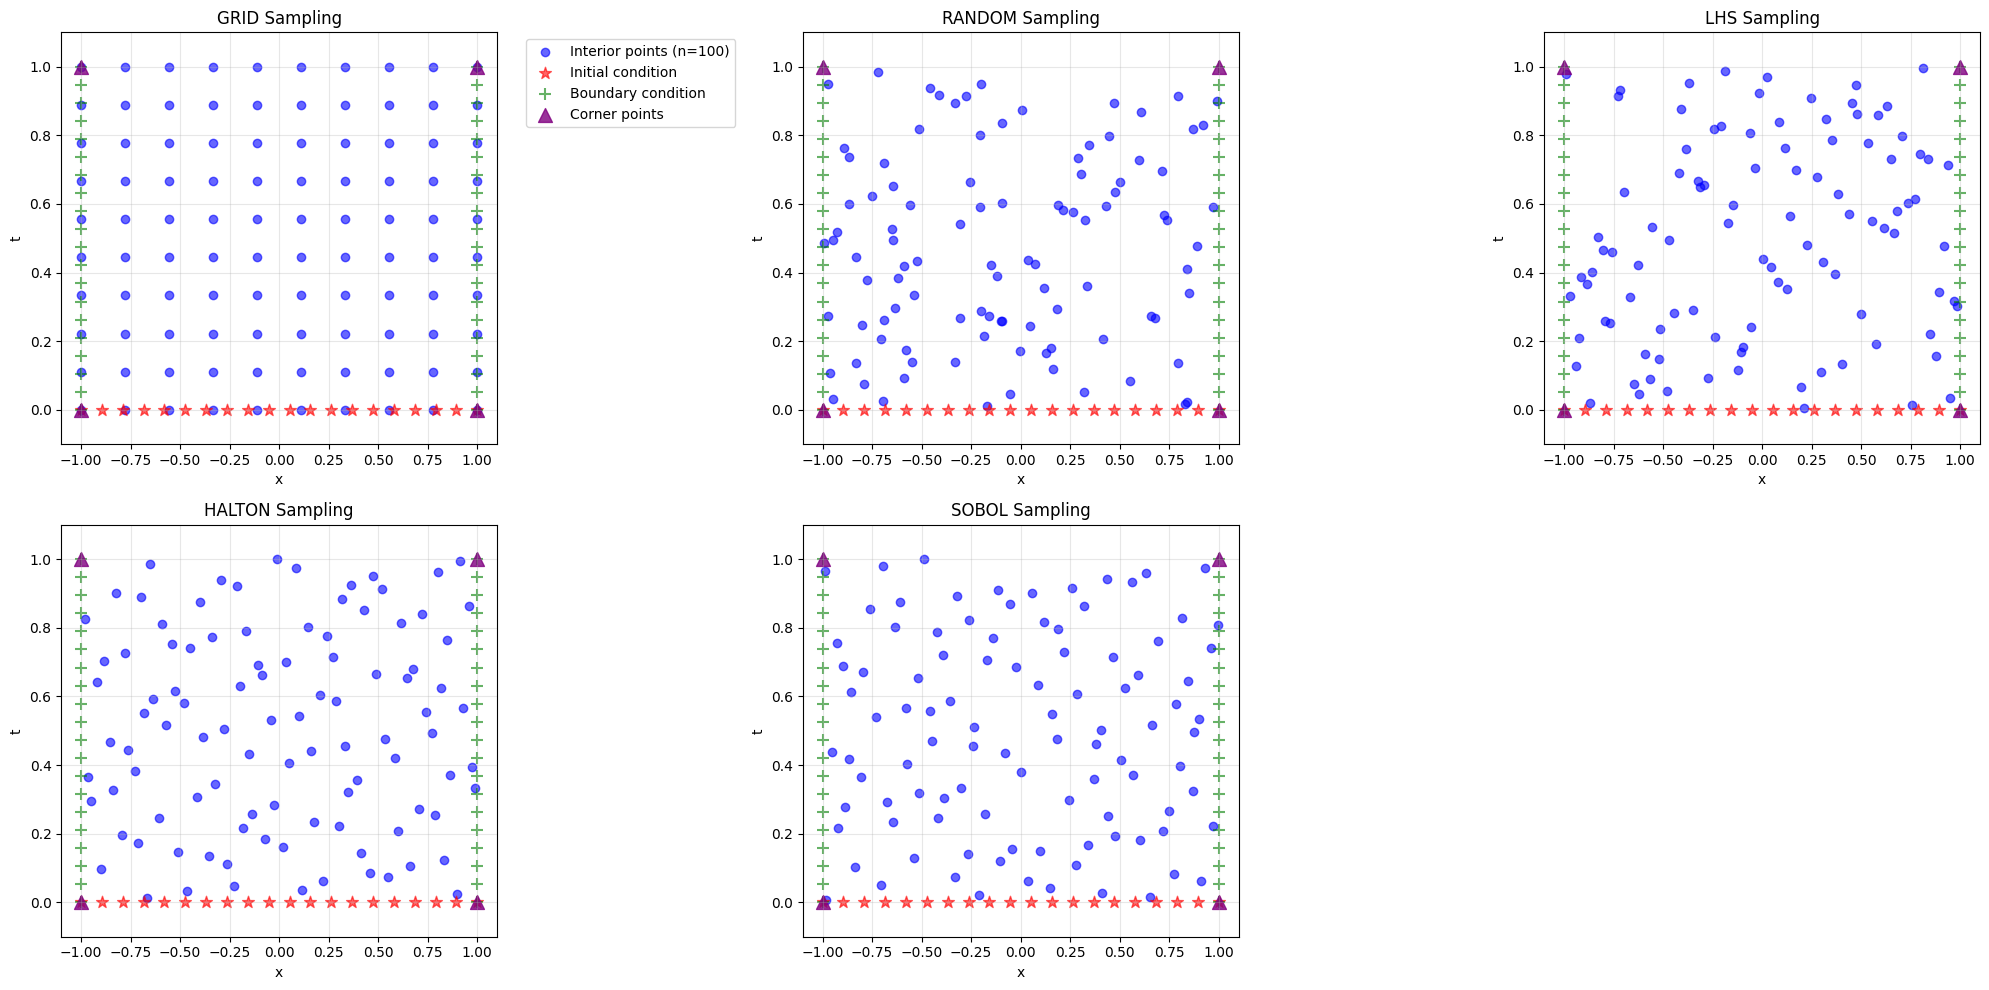

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
import seaborn as sns

def plot_collocation_points(n_points=40, figsize=(20, 10)):
    """
    Plot collocation points for different sampling methods.
    
    Args:
        n_points: Number of points to generate for each method
        figsize: Size of the figure (width, height)
    """
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()
    
    # Define sampling methods
    methods = ['grid', 'random', 'lhs', 'halton', 'sobol']
    
    for idx, method in enumerate(methods):
        ax = axes[idx]
        
        if method == 'grid':
            # Calculate number of points per dimension to get total points ≥ n_points
            n_per_dim = int(np.ceil(np.sqrt(n_points)))
            # Calculate spacing to get exactly n_points
            x_points = int(np.ceil(np.sqrt(n_points * 1.0)))
            y_points = int(np.ceil(n_points / x_points))
            while x_points * y_points > n_points:
                if (x_points - 1) * y_points >= n_points:
                    x_points -= 1
                elif x_points * (y_points - 1) >= n_points:
                    y_points -= 1
                else:
                    break
                    
            x = np.linspace(-1, 1, x_points)
            t = np.linspace(0, 1, y_points)
            X, T = np.meshgrid(x, t)
            points_x = X.flatten()[:n_points]
            points_t = T.flatten()[:n_points]
        
        elif method == 'random':
            # Generate random points
            points_x = np.random.uniform(-1, 1, n_points)
            points_t = np.random.uniform(0, 1, n_points)
        
        else:
            # Generate QMC points
            sampler = {
                'lhs': qmc.LatinHypercube(d=2),
                'halton': qmc.Halton(d=2),
                'sobol': qmc.Sobol(d=2)
            }[method]
            
            samples = sampler.random(n=n_points)
            points_x = 2 * samples[:, 0] - 1  # Scale to [-1, 1]
            points_t = samples[:, 1]          # Scale to [0, 1]
        
        # Plot points
        ax.scatter(points_x, points_t, c='blue', alpha=0.6, 
                  label=f'Interior points (n={len(points_x)})')
        
        # Add boundary points
        n_boundary = 20
        boundary_x = np.linspace(-1, 1, n_boundary)
        boundary_t = np.zeros_like(boundary_x)
        ax.scatter(boundary_x, boundary_t, c='red', alpha=0.6, s=80, marker='*', label='Initial condition')
        
        # Add periodic boundary points
        t_bc = np.linspace(0, 1, n_boundary)
        left_x = np.full_like(t_bc, -1)
        right_x = np.full_like(t_bc, 1)
        ax.scatter(left_x, t_bc, c='green', alpha=0.6, marker='+', s=80, label='Boundary condition')
        ax.scatter(right_x, t_bc, c='green', alpha=0.6, marker='+', s=80)
        
        # Add corner points
        corners_x = [-1, -1, 1, 1]
        corners_t = [0, 1, 0, 1]
        ax.scatter(corners_x, corners_t, c='purple', s=100, alpha=0.8, marker='^', label='Corner points')
        
        # Customize plot
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        ax.set_title(f'{method.upper()} Sampling')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        
        # Add legend to first plot only
        if idx == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Remove the extra subplot
    axes[-1].remove()
    
    plt.tight_layout()
    plt.show()

# Generate the visualization
plot_collocation_points(100)

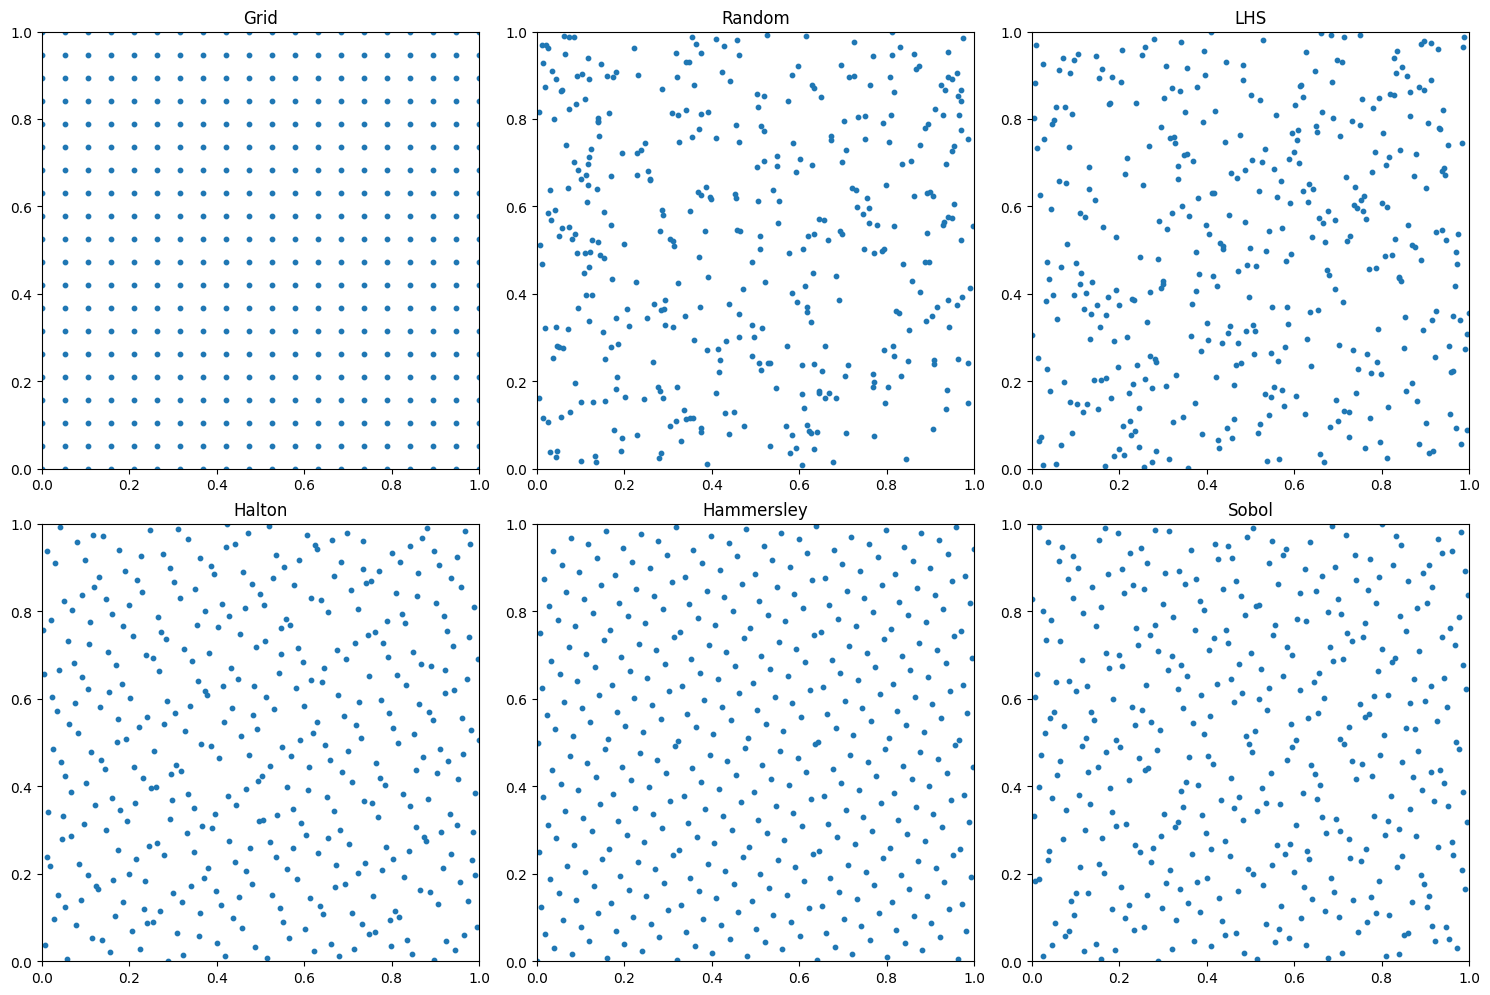

Shape of collocation points: (1000, 2)
Shape of boundary points: (100, 1)


In [25]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt

def generate_grid(n_points_1d, dim=2):
    """Generate uniform grid points."""
    points_1d = np.linspace(0, 1, n_points_1d)
    mesh = np.meshgrid(*[points_1d for _ in range(dim)])
    points = np.column_stack([m.flatten() for m in mesh])
    return points

def generate_random(n_points, dim=2):
    """Generate random uniform points."""
    return np.random.uniform(0, 1, (n_points, dim))

def generate_lhs(n_points, dim=2):
    """Generate Latin Hypercube Sampling points."""
    sampler = qmc.LatinHypercube(d=dim)
    points = sampler.random(n=n_points)
    return points

def generate_halton(n_points, dim=2):
    """Generate Halton sequence points."""
    sampler = qmc.Halton(d=dim)
    points = sampler.random(n=n_points)
    return points

def generate_hammersley(n_points, dim=2):
    """Generate Hammersley sequence points."""
    # Generate base sequence for first dimension
    points = np.zeros((n_points, dim))
    points[:, 0] = np.linspace(0, 1, n_points)
    
    # Generate remaining dimensions using van der Corput sequence
    for d in range(1, dim):
        base = d + 1
        for i in range(n_points):
            n = i
            phi = 0
            denominator = 1
            while n > 0:
                denominator *= base
                phi += (n % base) / denominator
                n //= base
            points[i, d] = phi
            
    return points

def generate_sobol(n_points, dim=2):
    """Generate Sobol sequence points."""
    sampler = qmc.Sobol(d=dim)
    points = sampler.random(n=n_points)
    return points

def plot_sampling_methods(n_points=400):
    """Plot all sampling methods."""
    # Calculate grid size for uniform grid
    n_points_1d = int(np.sqrt(n_points))
    
    # Generate points using different methods
    methods = {
        'Grid': generate_grid(n_points_1d),
        'Random': generate_random(n_points),
        'LHS': generate_lhs(n_points),
        'Halton': generate_halton(n_points),
        'Hammersley': generate_hammersley(n_points),
        'Sobol': generate_sobol(n_points)
    }
    
    # Create subplot
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.ravel()
    
    # Plot each sampling method
    for idx, (name, points) in enumerate(methods.items()):
        axs[idx].scatter(points[:, 0], points[:, 1], s=10)
        axs[idx].set_title(name)
        axs[idx].set_xlim([0, 1])
        axs[idx].set_ylim([0, 1])
        axs[idx].set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

# Generate and plot samples
np.random.seed(42)  # For reproducibility
plot_sampling_methods(400)

# Example of how to generate points for use in PINNs
if __name__ == "__main__":
    # Generate 1000 collocation points using LHS
    collocation_points = generate_lhs(1000, dim=2)
    print("Shape of collocation points:", collocation_points.shape)
    
    # Generate 100 boundary points using uniform grid
    boundary_points = generate_grid(100, dim=1)
    print("Shape of boundary points:", boundary_points.shape)